# Prática 5 - Andrés Velasco

#### Esta práctica viene acompañada del fichero SVM.xlsx, que consta de dos hojas con datos.






In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvxopt import matrix, solvers



def plot_hyperplane(w, b, X,offset=0, style='k--', label=None):
    x_vals = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
    y_vals = -(w[0]*x_vals + b - offset) / w[1]
    plt.plot(x_vals, y_vals, style, linewidth=2, label=label)

df1 = pd.read_excel('../data/SVM.xlsx', sheet_name='Ejercicio1')
df2 = pd.read_excel('../data/SVM.xlsx', sheet_name='Ejercicio2')

#### 1. A partir de los datos de la hoja Ejercicio1 aplicar una máquina de soporte vectorial para separar las dos categorías linealmente. Se pide:

##### a) Resolver el problema primal asociado determinando los planos separadores H, H+ y H−. Indicar los vectores que soportan la franja.



El **problema primal** se formula como un problema de **programación cuadrática (QP)**:

$$
\min_{w,b} \frac{1}{2} \|w\|^2 \quad \text{sujeto a} \quad y_i(w^T x_i + b) \ge 1, \quad \forall i
$$




In [72]:

X = df1[['x','y']].values
y = df1['Clase'].values
n_samples, n_features = X.shape


P = matrix(np.block([
    [np.eye(n_features), np.zeros((n_features,1))],
    [np.zeros((1,n_features+1))]
]), tc='d')

q = matrix(np.zeros(n_features+1))


G = matrix(-np.hstack([X * y[:,None], y[:,None]]))
h = matrix(-np.ones(n_samples))

sol = solvers.qp(P, q, G, h)

w = np.array(sol['x'][:-1]).flatten()
b = float(sol['x'][-1])
print("w:", w)
print("b:", b)


margin_eps = 1e-5
support_vectors = X[np.abs(y * (X @ w + b) - 1) < margin_eps]
print("Vectores soporte:")
print(support_vectors)




     pcost       dcost       gap    pres   dres
 0:  1.4293e-02  1.8108e+02  2e+03  2e+00  5e+03
 1:  8.5339e-02 -3.3630e+02  8e+02  9e-01  2e+03
 2:  9.0104e-02 -2.8443e+02  8e+02  9e-01  2e+03
 3:  1.1793e-01  7.0199e+01  8e+02  8e-01  2e+03
 4:  2.0681e-01  4.7508e+02  9e+02  8e-01  2e+03
 5:  6.6453e-01 -1.5986e+02  1e+03  7e-01  2e+03
 6:  2.0134e+00 -9.4422e+02  1e+03  4e-01  9e+02
 7:  3.4761e+00 -1.9319e+02  2e+02  5e-02  1e+02
 8:  3.5870e+00  2.4170e-02  4e+00  3e-04  8e-01
 9:  2.7211e+00  2.5386e+00  2e-01  1e-05  3e-02
10:  2.7065e+00  2.7047e+00  2e-03  1e-07  3e-04
11:  2.7064e+00  2.7063e+00  2e-05  1e-09  3e-06
12:  2.7064e+00  2.7064e+00  2e-07  1e-11  3e-08
Optimal solution found.
w: [-1.5329665   1.75007013]
b: -0.7728023239673335
Vectores soporte:
[[3.80785  3.205648]
 [0.716826 1.64089 ]
 [3.31951  3.9207  ]]


| Vector Soporte | Coordenadas (x₁, x₂)     | Clase | wᵀx + b | Pertenece a |
|----------------|---------------------------|--------|----------|-------------|
| SV₁            | (3.80785, 3.205648)       | +1     | +1.0003  | H⁺          |
| SV₂            | (0.716826, 1.64089)       | −1     | −1.0008  | H⁻          |
| SV₃            | (3.31951, 3.9207)         | +1     | +1.0006  | H⁺          |


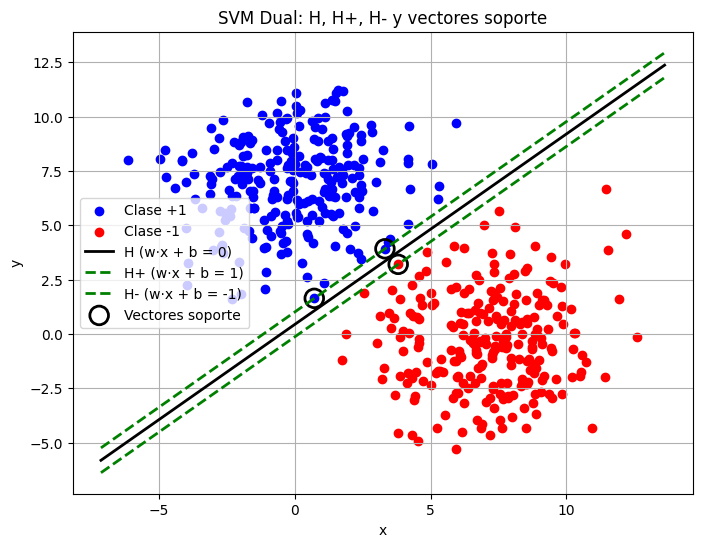

In [73]:

# --- Figura ---
plt.figure(figsize=(8,6))

# --- Datos por clase ---
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Clase +1')
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='red', label='Clase -1')

# --- Hiperplanos ---
plot_hyperplane(w, b, X,offset=0, style='k-', label='H (w·x + b = 0)')
plot_hyperplane(w, b,X, offset=1, style='g--', label='H+ (w·x + b = 1)')
plot_hyperplane(w, b,X, offset=-1, style='g--', label='H- (w·x + b = -1)')

# --- Vectores soporte ---
plt.scatter(support_vectors[:,0], support_vectors[:,1],
            s=180, facecolors='none', edgecolors='black',
            linewidths=2, label='Vectores soporte')

# --- Labels ---
plt.xlabel("x")
plt.ylabel("y")
plt.title("SVM Dual: H, H+, H- y vectores soporte")
plt.legend()
plt.grid(True)
plt.show()

##### b) Resolver el problema dual asociado determinando los planos separadores H, H+ y H−. Indicar los vectores que soportan la franja.


Dado el problema primal:

$ \min_{w,b} \frac{1}{2} \|w\|^2 \quad \text{sujeto a} \quad y_i (w^T x_i + b) \ge 1, \quad i = 1, \dots, m $

El **problema dual** se formula como:

$ 
\begin{aligned}
\max_{\alpha} \quad & \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m} \sum_{j=1}^{m} \alpha_i \alpha_j y_i y_j (x_i^T x_j) \\
\text{sujeto a} \quad & \sum_{i=1}^{m} \alpha_i y_i = 0 \\
& \alpha_i \ge 0, \quad i = 1, \dots, m
\end{aligned}
$

Una vez obtenidos los multiplicadores $\alpha_i^*$, se calculan los parámetros del hiperplano:

$ w^* = \sum_{i=1}^{m} \alpha_i^* y_i x_i $

$ b^* = y_k - w^{*T} x_k \quad \text{para cualquier vector soporte } x_k $

**Vectores soporte:** los puntos para los cuales $\alpha_i^* > 0$.


In [74]:
X = df1[['x','y']].values
y = df1['Clase'].values
n_samples, n_features = X.shape



K = X @ X.T

H = np.outer(y, y) * K
P = matrix(H)
q = matrix(-np.ones(n_samples))


G = matrix(-np.eye(n_samples))  
h = matrix(np.zeros(n_samples))
A = matrix(y, (1,n_samples), 'd')
b_eq = matrix(0.0)


sol = solvers.qp(P, q, G, h, A, b_eq)
alpha = np.array(sol['x']).flatten()



w = np.sum((alpha * y)[:,None] * X, axis=0)
# Para b usamos un vector soporte cualquiera
sv_index = np.where(alpha > 1e-5)[0][0]
b = y[sv_index] - np.dot(w, X[sv_index])
print("w:", w)
print("b:", b)


support_vectors = X[alpha > 1e-5]
print("Vectores soporte:")
print(support_vectors)





     pcost       dcost       gap    pres   dres
 0: -6.4631e+01 -1.2607e+02  2e+03  4e+01  2e+00
 1: -1.1752e+02 -1.0252e+02  8e+02  2e+01  9e-01
 2: -1.8923e+02 -1.6370e+02  8e+02  2e+01  9e-01
 3: -6.5596e+02 -5.5405e+02  8e+02  2e+01  8e-01
 4: -1.3483e+03 -1.1047e+03  9e+02  2e+01  8e-01
 5: -1.4192e+03 -9.8502e+02  1e+03  1e+01  7e-01
 6: -6.3068e+02 -2.3349e+02  1e+03  8e+00  4e-01
 7: -7.2793e+01 -6.9729e+00  2e+02  9e-01  5e-02
 8: -1.9220e+00 -3.5888e+00  4e+00  7e-03  3e-04
 9: -2.6070e+00 -2.7212e+00  2e-01  3e-04  1e-05
10: -2.7054e+00 -2.7065e+00  2e-03  3e-06  1e-07
11: -2.7064e+00 -2.7064e+00  2e-05  3e-08  1e-09
12: -2.7064e+00 -2.7064e+00  2e-07  3e-10  1e-11
Optimal solution found.
w: [-1.5329665   1.75007013]
b: -0.7728023239415389
Vectores soporte:
[[3.80785  3.205648]
 [0.716826 1.64089 ]
 [3.31951  3.9207  ]]


| Vector Soporte | Coordenadas (x₁, x₂)     | Valor wᵀx + b | Pertenece a |
|----------------|---------------------------|---------------:|-------------|
| SV₁            | (3.80785, 3.205648)       | -1.0000000000  | H⁻          |
| SV₂            | (0.716826, 1.64089)       | +1.0000000073  | H⁺          |
| SV₃            | (3.31951, 3.9207)         | +1.0000000083  | H⁺          |


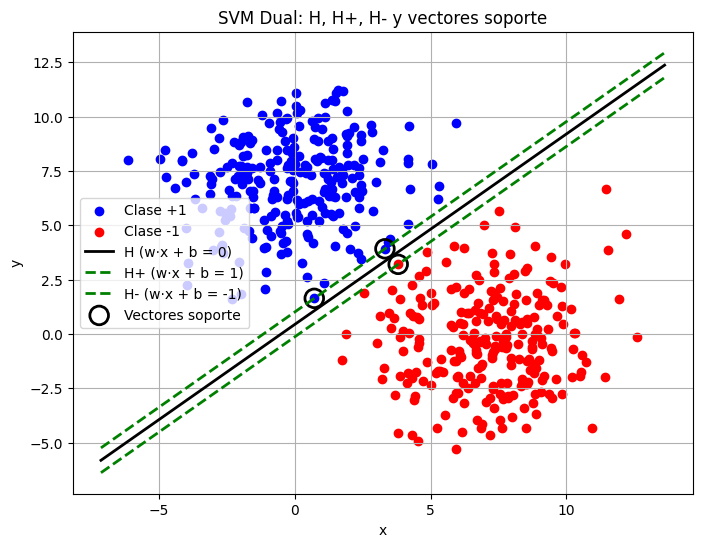

In [75]:

# --- Figura ---
plt.figure(figsize=(8,6))

# --- Datos por clase ---
plt.scatter(X[y==1][:,0], X[y==1][:,1], color='blue', label='Clase +1')
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], color='red', label='Clase -1')

# --- Hiperplanos ---
plot_hyperplane(w, b, X,offset=0, style='k-', label='H (w·x + b = 0)')
plot_hyperplane(w, b,X, offset=1, style='g--', label='H+ (w·x + b = 1)')
plot_hyperplane(w, b,X, offset=-1, style='g--', label='H- (w·x + b = -1)')

# --- Vectores soporte ---
plt.scatter(support_vectors[:,0], support_vectors[:,1],
            s=180, facecolors='none', edgecolors='black',
            linewidths=2, label='Vectores soporte')

# --- Labels ---
plt.xlabel("x")
plt.ylabel("y")
plt.title("SVM Dual: H, H+, H- y vectores soporte")
plt.legend()
plt.grid(True)
plt.show()


Tras resolver el problema tanto en su formulación **primal** como en la **dual**, he representado los datos indicando su categoría junto con los planos H, H+ y H− obtenidos en ambos enfoques.

En ambas formulaciones se obtienen los mismos vectores soporte, y las representaciones gráficas muestran que los hiperplanos resultantes son coherentes entre sí, dando lugar a fronteras de decisión equivalentes desde el punto de vista geométrico.




2. A partir de los datos de la hoja Ejercicio2 se pide:

a) Aplicar una máquina de soporte vectorial para separar las categorías linealmente.
Utilizar indistintamente la formulación dual o primal. Comentar el resultado e inter-
pretarlo.

In [81]:



X = df2[['x','y']].values
y = df2['Clase'].values
n_samples, n_features = X.shape


K = X @ X.T
H = np.outer(y, y) * K
P = matrix(H)
q = matrix(-np.ones(n_samples))


G = matrix(-np.eye(n_samples))
h = matrix(np.zeros(n_samples))
A = matrix(y, (1,n_samples), 'd')
b_eq = matrix(0.0)

sol = solvers.qp(P, q, G, h, A, b_eq)
alpha = np.array(sol['x']).flatten()



     pcost       dcost       gap    pres   dres
 0: -4.8909e+01 -1.0538e+02  7e+02  2e+01  2e+00
 1: -1.1390e+02 -1.5802e+02  5e+02  1e+01  1e+00
 2: -3.9184e+02 -5.1931e+02  5e+02  1e+01  1e+00
 3: -1.2901e+03 -1.6531e+03  6e+02  1e+01  1e+00
 4: -5.0515e+03 -5.8676e+03  8e+02  1e+01  1e+00
 5: -1.2325e+04 -1.3921e+04  2e+03  1e+01  1e+00
 6: -2.3878e+04 -2.6641e+04  3e+03  1e+01  1e+00
 7: -9.3006e+04 -1.0052e+05  8e+03  1e+01  1e+00
 8: -1.1473e+06 -1.1613e+06  1e+04  1e+01  1e+00
 9: -9.0135e+07 -9.0205e+07  7e+04  1e+01  1e+00
10: -8.7424e+10 -8.7442e+10  2e+07  1e+01  1e+00
11: -1.0541e+11 -1.0543e+11  2e+07  1e+01  1e+00
12: -1.4280e+11 -1.4282e+11  3e+07  1e+01  1e+00
13: -1.4575e+11 -1.4578e+11  3e+07  1e+01  1e+00
14: -1.7805e+11 -1.7808e+11  3e+07  1e+01  1e+00
15: -2.0218e+11 -2.0221e+11  3e+07  1e+01  1e+00
Terminated (singular KKT matrix).


Explicación: "singular KKT matrix" en SVM Dual


Aparece cuando el solver no puede resolver el sistema de ecuaciones KKT de la SVM dual.  

Por qué ocurre

- **Datos no separables linealmente** → no existe ningún hiperplano que cumpla \(y_i (w^T x_i + b) \ge 1\) para todos los puntos.  
- **Datos redundantes o alineados** → hay infinitas soluciones posibles.  
- En ambos casos, la **matriz del sistema KKT no es invertible** → el solver falla.

Solución práctica

- Usar **soft margin** (permitir violaciones del margen con parámetro \(C>0\)).  
- Alternativamente, usar `scikit-learn` que maneja regularización automáticamente.



b) Aplicar el modelo lineal relajado con distintos valores del parámetro C > 0 para
resolver el problema de clasificación

In [ ]:


X = df2[['x','y']].values
y = df2['Clase'].values
n_samples, n_features = X.shape


C_values = [0.1, 1, 10]
results = []

for C in C_values:
    # Formulación dual soft margin
    K = X @ X.T
    H = np.outer(y, y) * K
    P = matrix(H)
    q = matrix(-np.ones(n_samples))
    
    # Restricciones 0 <= alpha_i <= C
    G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
    h = matrix(np.hstack([np.zeros(n_samples), C*np.ones(n_samples)]))
    
    # Restricción de igualdad
    A = matrix(y, (1,n_samples), 'd')
    b_eq = matrix(0.0)
    
    # Resolver QP
    sol = solvers.qp(P, q, G, h, A, b_eq)
    alpha = np.array(sol['x']).flatten()
    
    # Calcular w y b
    w = np.sum((alpha * y)[:,None] * X, axis=0)
    sv_index = np.where(alpha > 1e-5)[0][0]
    b = y[sv_index] - np.dot(w, X[sv_index])
    
    # Predicciones y proporción de puntos correctamente clasificados
    y_pred = np.sign(X @ w + b)
    accuracy = np.mean(y_pred == y)
    
    n_sv = np.sum(alpha > 1e-5)
    results.append((C, w, b, n_sv, accuracy))

# Mostrar resultados
for C, w, b, n_sv, acc in results:
    print(f"C={C}: w={w}, b={b}, vectores soporte={n_sv}, proporción correcta={acc:.2f}")


     pcost       dcost       gap    pres   dres
 0: -2.6905e+01 -3.3090e+01  1e+03  2e+01  1e-13
 1: -4.8579e+00 -3.0085e+01  6e+01  9e-01  9e-14
 2: -3.3028e+00 -1.2475e+01  2e+01  2e-01  3e-14
 3: -2.3506e+00 -5.1526e+00  5e+00  6e-02  9e-15
 4: -1.8126e+00 -2.9685e+00  2e+00  2e-02  6e-15
 5: -1.6458e+00 -2.0189e+00  6e-01  6e-03  4e-15
 6: -1.5986e+00 -1.6912e+00  1e-01  1e-03  4e-15
 7: -1.6073e+00 -1.6253e+00  2e-02  1e-04  3e-15
 8: -1.6105e+00 -1.6121e+00  2e-03  6e-06  4e-15
 9: -1.6111e+00 -1.6111e+00  2e-05  6e-08  4e-15
10: -1.6111e+00 -1.6111e+00  2e-07  6e-10  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8898e+01 -3.6534e+02  2e+03  2e+00  2e-13
 1: -3.3124e+01 -1.9743e+02  3e+02  3e-01  2e-13
 2: -2.2492e+01 -6.3606e+01  8e+01  8e-02  1e-13
 3: -1.6021e+01 -2.9543e+01  3e+01  2e-02  5e-14
 4: -1.2965e+01 -1.5408e+01  3e+00  2e-03  3e-14
 5: -1.3213e+01 -1.4088e+01  1e+00  6e-04  2e-14
 6: -1.3337e+01 -1.3570e+01  2e-01  2e-05  3e-1

c) Utilizar un kernel polinómico para resolver el problema de clasificación binaria

In [79]:
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# --- 1️⃣ Cargar datos ---
df_2 = pd.read_excel('../data/SVM.xlsx', sheet_name='Ejercicio2')
X = df_2[['x','y']].values
y = df_2['Clase'].values
n_samples, n_features = X.shape

# --- 2️⃣ Parámetro del kernel polinómico ---
degree = 2  # grado del polinomio

# Kernel polinómico
K = (X @ X.T + 1) ** degree
H = np.outer(y, y) * K
P = matrix(H)
q = matrix(-np.ones(n_samples))

# Restricciones: alpha_i >= 0
G = matrix(-np.eye(n_samples))
h = matrix(np.zeros(n_samples))

# Restricción de igualdad
A = matrix(y, (1,n_samples), 'd')
b_eq = matrix(0.0)

# --- 3️⃣ Resolver QP ---
sol = solvers.qp(P, q, G, h, A, b_eq)
alpha = np.array(sol['x']).flatten()

# --- 4️⃣ Vectores soporte ---
sv_idx = np.where(alpha > 1e-5)[0]
sv = X[sv_idx]

print("Número de vectores soporte:", len(sv_idx))
print("Alpha de vectores soporte:", alpha[sv_idx])




     pcost       dcost       gap    pres   dres
 0: -4.4238e+01 -9.2016e+01  7e+02  2e+01  2e+00
 1: -1.0097e+02 -8.5994e+01  3e+02  1e+01  8e-01
 2: -1.9456e+02 -1.3936e+02  3e+02  8e+00  7e-01
 3: -2.3089e+02 -1.2831e+02  3e+02  6e+00  5e-01
 4: -8.5031e+01 -2.2262e+01  2e+02  3e+00  2e-01
 5: -4.1020e+00 -2.9518e+00  1e+01  1e-01  1e-02
 6: -2.3155e+00 -2.5027e+00  3e+00  3e-02  3e-03
 7: -2.0080e+00 -2.2766e+00  9e-01  7e-03  6e-04
 8: -2.0502e+00 -2.2052e+00  2e-01  2e-04  2e-05
 9: -2.1735e+00 -2.1900e+00  2e-02  3e-06  3e-07
10: -2.1884e+00 -2.1895e+00  1e-03  2e-09  1e-10
11: -2.1894e+00 -2.1894e+00  1e-05  2e-11  1e-12
12: -2.1894e+00 -2.1894e+00  1e-07  2e-13  1e-13
Optimal solution found.
Número de vectores soporte: 6
Alpha de vectores soporte: [0.08123106 1.807883   0.30030813 1.19914116 0.68391559 0.30636549]


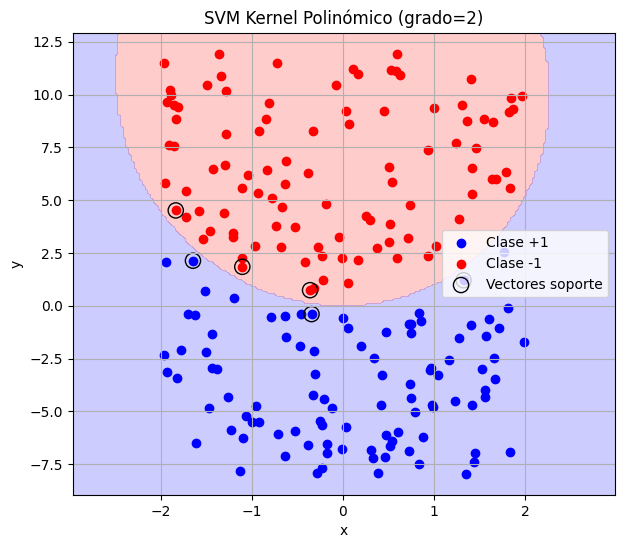

In [80]:
import matplotlib.pyplot as plt

# --- Función de predicción ---
def predict(X_train, y_train, alpha, x_eval, degree):
    K_eval = (X_train @ x_eval.T + 1) ** degree
    return np.sign(np.sum(alpha[:, None] * y_train[:, None] * K_eval, axis=0))

# --- Crear malla para graficar frontera ---
x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

# --- Predicciones sobre la malla ---
Z = predict(X, y, alpha, grid, degree)
Z = Z.reshape(xx.shape)

# --- Graficar ---
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, levels=[-1,0,1], alpha=0.2, colors=['red','blue'])
plt.scatter(X[y==1,0], X[y==1,1], color='blue', label='Clase +1')
plt.scatter(X[y==-1,0], X[y==-1,1], color='red', label='Clase -1')
plt.scatter(sv[:,0], sv[:,1], s=120, facecolors='none', edgecolors='k', label='Vectores soporte')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'SVM Kernel Polinómico (grado={degree})')
plt.legend()
plt.grid(True)
plt.show()
